In [1]:
import trackpy as tp 
import pims
import glob
import numpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import bmc
from tqdm import trange

## Onion 2

In [2]:
path = "../data/onion_2/Onion_bulk_20x/*.bmp"
nfiles = len(glob.glob(path))

# um_per_px for each zoom
x10 = 9.51/13
x20 = 9.51/24
x40 = 9.51/57
fps = 30
#frames = pims.as_grey(pims.open(path))

Frame 357: 16 trajectories present.


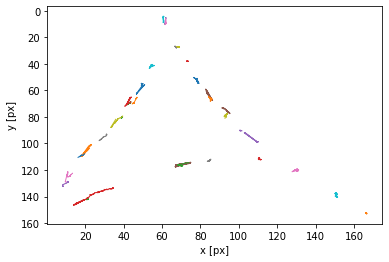

In [3]:
f = bmc.annotate(path, show=False, diameter=11, minmass=150, crop=((0,26), (27,0)))
t = bmc.get_trajectories(f, show=True, diameter=11, minmass=150, search_range=10, clip_stubs=50)

In [4]:
all_v, x_v, y_v = bmc.particle_velocity(t, 0, x20, 30)

Text(0.5, 1.0, 'velocity histogram')

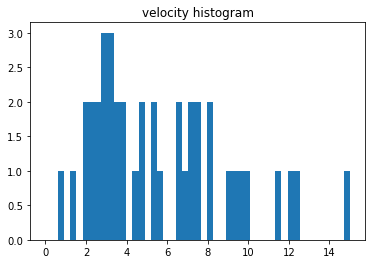

In [5]:
plt.figure()
_ = plt.hist(all_v, bins=np.linspace(0, 15))
plt.title("velocity histogram")

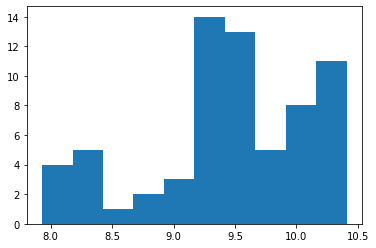

In [6]:
plt.figure()
_ = plt.hist(bmc.viscosity(t, 1, x20, 30))

In [7]:
t[t["frame"]==0]["particle"].values

array([ 0,  1,  2,  4,  6,  7, 11, 13, 14, 15, 16, 19, 21])

## Onion 4

Frame 249: 19 trajectories present.


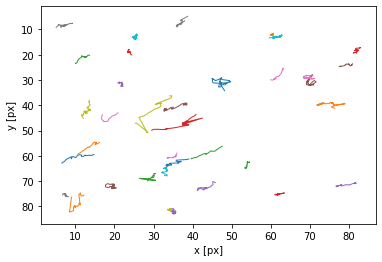

../data/onion_4/Onion_bulk_20x-11


In [8]:
i = 19
folder_paths = glob.glob("../data/onion_4/*")
path = folder_paths[i] + "/*bmp"

f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
t = bmc.get_trajectories(f, show=True, diameter=11, minmass=10, search_range=6, clip_stubs=25)
print(folder_paths[i])

In [9]:
lengths = []
for folder in folder_paths:
    files = glob.glob(folder + "/*bmp")
    lengths.append(len(files))

In [10]:
def all_viscosity(t):
    all_visc = np.array([])
    for i in np.unique(t["particle"]):
        all_visc = np.append(all_visc, np.mean(bmc.viscosity(t, i, x20, fps)))
    return all_visc

def all_velocity(t):
    all_vel = np.array([])
    x_vel = np.array([])
    y_vel = np.array([])
    mean_dx = np.array([])
    mean_dy = np.array([])
    for i in np.unique(t["particle"]):
        mean_dx = np.append(mean_dx, np.mean(np.diff(t["x"])))
        mean_dy = np.append(mean_dy, np.mean(np.diff(t["y"])))
        mag, x, y = bmc.particle_velocity(t, i, x20, fps)
        all_vel = np.append(all_vel, np.mean(mag))
        x_vel = np.append(x_vel, np.mean(x))
        y_vel = np.append(y_vel, np.mean(y))
    return all_vel, x_vel, y_vel, mean_dx, mean_dy

In [11]:
total_velocities = np.array([])
x_velocities = np.array([])
y_velocities = np.array([])
all_viscosities= np.array([])
dx = np.array([])
dy = np.array([])
for folder in folder_paths:
    path = folder + "/*bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)
    mag, x, y, mdx, mdy = all_velocity(t)
    mask = (mdx > 1e-4) + (mdy > 1e-4)
    dx = np.append(dx, mdx)
    dy = np.append(dy, mdy)
    total_velocities = np.append(total_velocities, mag[mask])
    x_velocities = np.append(x_velocities, x[mask])
    y_velocities = np.append(y_velocities, y[mask])
    all_viscosities= np.append(all_viscosities, all_viscosity(t)[mask])

Frame 84: 15 features


Process ForkPoolWorker-19:
Traceback (most recent call last):
Process ForkPoolWorker-17:
  File "/Users/DanielBautista/opt/miniconda3/envs/astroconda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [ ]:
len(np.unique(total_velocities)), len(np.unique(all_viscosities))

In [ ]:
plt.figure()
cnts,_,_ = plt.hist(total_velocities, bins=40)#, bins=np.linspace(0,13))
plt.xlabel("velocity [um/s]");

In [ ]:
bins = np.linspace(-10,10,40)
plt.figure()
_ = plt.hist2d(x_velocities, y_velocities, bins=(40, 40), cmap="Spectral_r")
plt.colorbar()
plt.xlabel("average x velocity [um/s]")
plt.ylabel("average y velocity [um/s]");

In [ ]:
bins = np.linspace(-10,10,40)
plt.figure()
_ = plt.hist2d(x_velocities, y_velocities, bins=(40, 40), cmap="Spectral_r")
plt.colorbar()
plt.xlabel("average x velocity [um/s]")
plt.ylabel("average y velocity [um/s]");

In [ ]:
plt.figure()
cnts,_,_ = plt.hist(all_viscosities, bins=np.linspace(0,100, 100), density=1)#, bins=np.linspace(0,13))
plt.xlabel("viscosity [mPa s]");

## Working with the good trajectory data

In [12]:
good_traj = ["Onion_bulk_20x-13", "Onion_bulk_20x-17", "Onion_bulk_20x-18", "Onion_bulk_20x-19",
             "Onion_bulk_20x-21", "Onion_bulk_20x-24", "Onion_bulk_20x-25", "Onion_bulk_20x-26",
             "Onion_bulk_20x-28"]

In [13]:
def all_velocity_threshold(t, threshold):
    all_vel = np.array([])
    x_vel = np.array([])
    y_vel = np.array([])
    for i in np.unique(t["particle"]):
#         mean_dx = np.append(mean_dx, np.mean(np.diff(t["x"])))
#         mean_dy = np.append(mean_dy, np.mean(np.diff(t["y"])))
        df = t[t["particle"]==i]
        dx = np.diff(df["x"])
        dy = np.diff(df["y"])
        disp = np.sum(np.sqrt(dx**2 + dx**2))
        if disp > threshold:
            mag, x, y = bmc.particle_velocity(t, i, x20, fps)
            all_vel = np.append(all_vel, np.mean(mag))
            x_vel = np.append(x_vel, np.mean(x))
            y_vel = np.append(y_vel, np.mean(y))
    return all_vel, x_vel, y_vel

def all_viscosity_threshold(t, threshold):
    all_visc = np.array([])
    for i in np.unique(t["particle"]):
        df = t[t["particle"]==i]
        dx = np.diff(df["x"])
        dy = np.diff(df["y"])
        disp = np.sum(np.sqrt(dx**2 + dx**2))
        if disp > threshold:
            all_visc = np.append(all_visc, np.mean(bmc.viscosity(t, i, x20, fps)))
    return all_visc

In [14]:
threshold = 5

total_velocities = np.array([])
x_velocities = np.array([])
y_velocities = np.array([])

for directory in good_traj:
    path = "../data/onion_4/" + directory + "/*.bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)

    all_vel, x_vel, y_vel = all_velocity_threshold(t, threshold)
    total_velocities = np.append(total_velocities, all_vel)
    x_velocities = np.append(x_velocities, x_vel)
    y_velocities = np.append(y_velocities, y_vel)

Frame 249: 13 trajectories present.


average velocity = 21.959139008220177


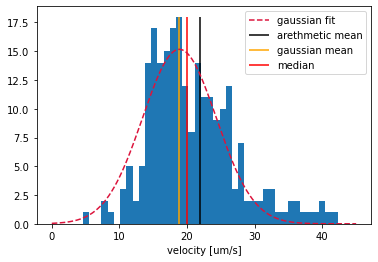

In [98]:
from scipy.optimize import curve_fit
def gaussian(x, amp, mu, sigma):
    return amp*np.exp(-0.5 * (x - mu)**2/sigma**2) 

def two_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    return amp1*np.exp(-0.5 * (x - mu1)**2/sigma1**2) + amp2*np.exp(-0.5 * (x - mu2)**2/sigma2**2) 

bins = np.linspace(0, 45)

plt.figure()
bin_height, bin_edges, _ = plt.hist(total_velocities, bins=bins)#, bins=np.linspace(0,13))
plt.xlabel("velocity [um/s]");
print("average velocity =", np.mean(total_velocities))

popt, pcov = curve_fit(gaussian, bin_edges[:-1], bin_height, p0=(20, 20, 20))
xx = np.linspace(np.min(bin_edges), np.max(bin_edges), 1000)
yy = gaussian(xx, *popt)
plt.plot(xx, yy, linestyle="--", color="crimson", label="gaussian fit")
plt.vlines(np.mean(total_velocities), 0, 18, color="black", label="arethmetic mean")
plt.vlines(popt[1], 0, 18, color="orange", label="gaussian mean")
plt.vlines(np.median(total_velocities), 0, 18, color="red", label="median")
plt.legend();

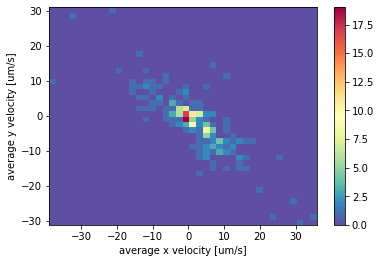

In [16]:
bins = np.linspace(-10,10,40)
plt.figure()
_ = plt.hist2d(x_velocities, y_velocities, bins=(40, 40), cmap="Spectral_r")
plt.colorbar()
plt.xlabel("average x velocity [um/s]")
plt.ylabel("average y velocity [um/s]");

## Working with the good brownian motion data

In [17]:
brownian = ["Onion_bulk_20x-6", "Onion_bulk_20x-16", "Onion_bulk_20x-27", "Onion_bulk_20x-29"]

In [18]:
threshold = 5

all_viscosities= np.array([])

for directory in brownian:
    path = "../data/onion_4/" + directory + "/*.bmp"
    f = bmc.annotate(path, show=False, diameter=11, minmass=10)#, crop=((0,26), (27,0)))
    t = bmc.get_trajectories(f, show=False, diameter=11, minmass=10, search_range=6, clip_stubs=25)

    all_visc = all_viscosity_threshold(t, threshold)
    all_viscosities = np.append(all_viscosities, all_visc)

Frame 250: 13 trajectories present.


average viscosity = 2.251233200304483


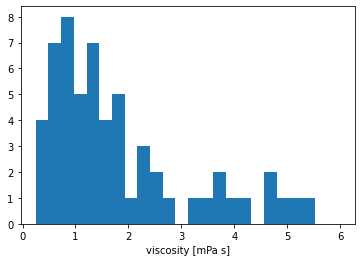

In [39]:
bins = np.linspace(0.25,6, 25)

plt.figure()
bin_height, bin_edgs, _ = plt.hist(all_viscosities, bins=bins)#, bins=np.linspace(0,13))
plt.xlabel("viscosity [mPa s]");
print("average viscosity =", np.mean(all_viscosities))

average viscosity (from array mean) = 2.2512 +- 4.5131
average viscosity (from gaussian)   = 0.8208 +- 0.1634


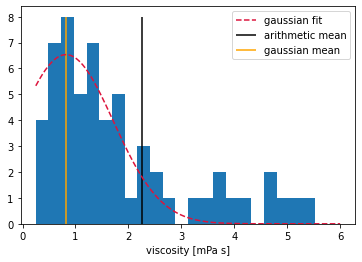

In [94]:
bins = np.linspace(0.25,6, 25)
rnd = 4


plt.figure()
bin_height, bin_edgs, _ = plt.hist(all_viscosities, bins=bins)#, bins=np.linspace(0,13))
plt.xlabel("viscosity [mPa s]");
print("average viscosity (from array mean) = %s +- %s"%(np.round(np.mean(all_viscosities), rnd), np.round(np.std(all_viscosities), rnd)))
popt, pcov = curve_fit(gaussian, bin_edgs[:-1], bin_height, p0=(10, 1, 1))
xx = np.linspace(np.min(bin_edgs), np.max(bin_edgs), 1000)
yy = gaussian(xx, *popt)
plt.plot(xx, yy, linestyle="--", color="crimson", label="gaussian fit")
print("average viscosity (from gaussian)   = %s +- %s"%(np.round(popt[1], rnd), np.round(np.sqrt(np.diag(pcov))[1], rnd)))
plt.vlines(np.mean(all_viscosities),0, 8, label="arithmetic mean",color="black")
plt.vlines(popt[1], 0,8, label="gaussian mean", color="orange")
plt.legend();

In [83]:
np.sqrt(np.diag(pcov))[1]

0.16343815135672504

In [84]:
pcov

array([[ 0.35264778,  0.01294204, -0.04623295],
       [ 0.01294204,  0.02671203, -0.01828   ],
       [-0.04623295, -0.01828   ,  0.02674044]])